In [ ]:
!pip install inception

In [ ]:
!pip install -q git+https://github.com/tensorflow/docs

In [ ]:
!wget -q https://git.io/JGc31 -O ucf101_top5.tar.gz
!tar xf ucf101_top5.tar.gz

In [ ]:

%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import numpy as np
import imageio
import cv2
import os
import pandas as pd

# Functions and classes for loading and using the Inception model.

from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint
from tensorflow_docs.vis import embed
from imutils import paths


In [ ]:
# example of loading the inception v3 model
from keras.applications.inception_v3 import InceptionV3
# load model
model = InceptionV3()
# summarize the model
model.summary()

96124928/96112376 [==============================] - 1s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)           

In [ ]:
IMG_SIZE = 224
BATCH_SIZE = 64
EPOCHS = 10

MAX_SEQ_LENGTH = 20
NUM_FEATURES = 2048

In [ ]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

print(f"Total videos for training: {len(train_df)}")
print(f"Total videos for testing: {len(test_df)}")

train_df.sample(10)

Total videos for training: 594
Total videos for testing: 224


,video_name,tag
180,v_PlayingCello_g17_c04.avi,PlayingCello
396,v_ShavingBeard_g14_c01.avi,ShavingBeard
29,v_CricketShot_g12_c02.avi,CricketShot
373,v_ShavingBeard_g10_c01.avi,ShavingBeard
179,v_PlayingCello_g17_c03.avi,PlayingCello
555,v_TennisSwing_g19_c04.avi,TennisSwing
82,v_CricketShot_g20_c04.avi,CricketShot
270,v_Punch_g12_c06.avi,Punch
369,v_ShavingBeard_g09_c04.avi,ShavingBeard
445,v_ShavingBeard_g21_c03.avi,ShavingBeard


In [ ]:
def crop_center_square(frame):
    y, x = frame.shape[0:2]
    min_dim = min(y, x)
    start_x = (x // 2) - (min_dim // 2)
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y : start_y + min_dim, start_x : start_x + min_dim]


def load_video(path, max_frames=0, resize=(IMG_SIZE, IMG_SIZE)):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = crop_center_square(frame)
            frame = cv2.resize(frame, resize)
            frame = frame[:, :, [2, 1, 0]]
            frames.append(frame)

            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    return np.array(frames)


In [ ]:

def classify(image_path):
    # Display the image.
    display(Image(image_path))

    # Use the Inception model to classify the image.
    pred = model.classify(image_path=image_path)

    # Print the scores and names for the top-10 predictions.
    model.print_scores(pred=pred, k=10, only_first_name=True)

In [ ]:


def build_feature_extractor():
    feature_extractor = keras.applications.InceptionV3(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )
    preprocess_input = keras.applications.inception_v3.preprocess_input

    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")


feature_extractor = build_feature_extractor()

87924736/87910968 [==============================] - 1s 0us/step


In [ ]:

label_processor = keras.layers.StringLookup(
    num_oov_indices=0, vocabulary=np.unique(train_df["tag"])
)
print(label_processor.get_vocabulary())

['CricketShot', 'PlayingCello', 'Punch', 'ShavingBeard', 'TennisSwing']


In [ ]:
def prepare_all_videos(df, root_dir):
    num_samples = len(df)
    video_paths = df["video_name"].values.tolist()
    labels = df["tag"].values
    labels = label_processor(labels[..., None]).numpy()

    # `frame_masks` and `frame_features` are what we will feed to our sequence model.
    # `frame_masks` will contain a bunch of booleans denoting if a timestep is
    # masked with padding or not.
    frame_masks = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH), dtype="bool")
    frame_features = np.zeros(
        shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
    )

    # For each video.
    for idx, path in enumerate(video_paths):
        # Gather all its frames and add a batch dimension.
        frames = load_video(os.path.join(root_dir, path))
        frames = frames[None, ...]

        # Initialize placeholders to store the masks and features of the current video.
        temp_frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
        temp_frame_features = np.zeros(
            shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
        )

        # Extract features from the frames of the current video.
        for i, batch in enumerate(frames):
            video_length = batch.shape[0]
            length = min(MAX_SEQ_LENGTH, video_length)
            for j in range(length):
                temp_frame_features[i, j, :] = feature_extractor.predict(
                    batch[None, j, :]
                )
            temp_frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

        frame_features[idx,] = temp_frame_features.squeeze()
        frame_masks[idx,] = temp_frame_mask.squeeze()

    return (frame_features, frame_masks), labels


train_data, train_labels = prepare_all_videos(train_df, "train")
test_data, test_labels = prepare_all_videos(test_df, "test")

print(f"Frame features in train set: {train_data[0].shape}")
print(f"Frame masks in train set: {train_data[1].shape}")

Frame features in train set: (594, 20, 2048)
Frame masks in train set: (594, 20)


In [ ]:

# Utility for our sequence model.
def get_sequence_model():
    class_vocab = label_processor.get_vocabulary()

    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
    mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")

   
    x = keras.layers.GRU(16, return_sequences=True)(
        frame_features_input, mask=mask_input
    )
    x = keras.layers.GRU(8)(x)
    x = keras.layers.Dropout(0.4)(x)
    x = keras.layers.Dense(8, activation="relu")(x)
    output = keras.layers.Dense(len(class_vocab), activation="softmax")(x)

    rnn_model = keras.Model([frame_features_input, mask_input], output)

    rnn_model.compile(
        loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
    )
    return rnn_model


# Utility for running experiments.
def run_experiment():
    filepath = "/tmp/video_classifier"
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, save_weights_only=True, save_best_only=True, verbose=1
    )

    seq_model = get_sequence_model()
    history = seq_model.fit(
        [train_data[0], train_data[1]],
        train_labels,
        validation_split=0.3,
        epochs=EPOCHS,
        callbacks=[checkpoint],
    )

    seq_model.load_weights(filepath)
    _, accuracy = seq_model.evaluate([test_data[0], test_data[1]], test_labels)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return history, seq_model


_, sequence_model = run_experiment()

Epoch 1/10
13/13 [==============================] - ETA: 0s - loss: 1.2591 - accuracy: 0.4410
Epoch 1: val_loss improved from inf to 1.84604, saving model to /tmp/video_classifier
13/13 [==============================] - 11s 289ms/step - loss: 1.2591 - accuracy: 0.4410 - val_loss: 1.8460 - val_accuracy: 0.0000e+00
Epoch 2/10
13/13 [==============================] - ETA: 0s - loss: 1.0103 - accuracy: 0.6530
Epoch 2: val_loss improved from 1.84604 to 1.66455, saving model to /tmp/video_classifier
13/13 [==============================] - 1s 52ms/step - loss: 1.0103 - accuracy: 0.6530 - val_loss: 1.6645 - val_accuracy: 0.0559
Epoch 3/10
13/13 [==============================] - ETA: 0s - loss: 0.9193 - accuracy: 0.7470
Epoch 3: val_loss did not improve from 1.66455
13/13 [==============================] - 1s 50ms/step - loss: 0.9193 - accuracy: 0.7470 - val_loss: 1.6785 - val_accuracy: 0.0223
Epoch 4/10
12/13 [==========================>...] - ETA: 0s - loss: 0.8637 - accuracy: 0.7839
Epoch

Test video path: v_CricketShot_g02_c06.avi
  CricketShot: 29.08%
  Punch: 23.95%
  TennisSwing: 20.03%
  PlayingCello: 13.51%
  ShavingBeard: 13.44%



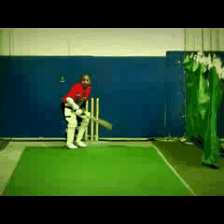

In [ ]:


def prepare_single_video(frames):
    frames = frames[None, ...]
    frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
    frame_features = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

    for i, batch in enumerate(frames):
        video_length = batch.shape[0]
        length = min(MAX_SEQ_LENGTH, video_length)
        for j in range(length):
            frame_features[i, j, :] = feature_extractor.predict(batch[None, j, :])
        frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

    return frame_features, frame_mask


def sequence_prediction(path):
    class_vocab = label_processor.get_vocabulary()

    frames = load_video(os.path.join("test", path))
    frame_features, frame_mask = prepare_single_video(frames)
    probabilities = sequence_model.predict([frame_features, frame_mask])[0]

    for i in np.argsort(probabilities)[::-1]:
        print(f"  {class_vocab[i]}: {probabilities[i] * 100:5.2f}%")
    return frames


# This utility is for visualization.

def to_gif(images):
    converted_images = images.astype(np.uint8)
    imageio.mimsave("animation.gif", converted_images, fps=10)
    return embed.embed_file("animation.gif")


test_video = np.random.choice(test_df["video_name"].values.tolist())
print(f"Test video path: {test_video}")
test_frames = sequence_prediction(test_video)
to_gif(test_frames[:MAX_SEQ_LENGTH])

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(5, input_shape=(3,)),
    tf.keras.layers.Softmax()])
model.save('/tmp/model')
loaded_model = tf.keras.models.load_model('/tmp/model')
x = tf.random.uniform((10, 3))
assert np.allclose(model.predict(x), loaded_model.predict(x))

INFO:tensorflow:Assets written to: /tmp/model/assets


In [ ]:
tf.keras.models.save_model(model,'my-model.hdf5')

In [ ]:
!pip install streamlit

     |████████████████████████████████| 10.1 MB 4.8 MB/s 
     |████████████████████████████████| 111 kB 39.4 MB/s 
     |████████████████████████████████| 181 kB 43.9 MB/s 
     |████████████████████████████████| 164 kB 51.5 MB/s 
     |████████████████████████████████| 76 kB 4.3 MB/s 
     |████████████████████████████████| 4.3 MB 42.7 MB/s 
     |████████████████████████████████| 63 kB 1.3 MB/s 
     |████████████████████████████████| 130 kB 40.8 MB/s 
     |████████████████████████████████| 130 kB 52.3 MB/s 
     |████████████████████████████████| 428 kB 43.8 MB/s 
     |████████████████████████████████| 793 kB 51.8 MB/s 
     |████████████████████████████████| 381 kB 51.4 MB/s 
  Created wheel for blinker: filename=blinker-1.4-py3-none-any.whl size=13478 sha256=1660d530f799add8d39b085f866ae68d3ca6ba091825719d9b17d2f950736feb
  Stored in directory: /root/.cache/pip/wheels/22/f5/18/df711b66eb25b21325c132757d4314db9ac5e8dabeaf196eab
Successfully built blinker
  Attempting uninstall: 

In [ ]:
%%writefile app.py
import streamlit as st
import tensorflow as tf
import streamlit as st


@st.cache(allow_output_mutation=True)
def load_model():
  model=tf.keras.models.load_model('/content/my_model2.hdf5')
  return model
with st.spinner('Model is being loaded..'):
  model=load_model()

st.write("""
         # Sport Classification
         """
         )

file = st.file_uploader("Please upload an brain scan file", type=["jpg", "png"])
import cv2
from PIL import Image, ImageOps
import numpy as np
st.set_option('deprecation.showfileUploaderEncoding', False)
def import_and_predict(image_data, model):
    
        size = (180,180)    
        image = ImageOps.fit(image_data, size, Image.ANTIALIAS)
        image = np.asarray(image)
        img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #img_resize = (cv2.resize(img, dsize=(75, 75),    interpolation=cv2.INTER_CUBIC))/255.
        
        img_reshape = img[np.newaxis,...]
    
        prediction = model.predict(img_reshape)
        
        return prediction
if file is None:
    st.text("Please upload an image file")
else:
    image = Image.open(file)
    st.image(image, use_column_width=True)
    predictions = import_and_predict(image, model)
    score = tf.nn.softmax(predictions[0])
    st.write(prediction)
    st.write(score)
    print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)


In [ ]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip

--2022-04-10 19:52:23--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 54.237.133.81, 18.205.222.128, 52.202.168.65, ...
Connecting to bin.equinox.io (bin.equinox.io)|54.237.133.81|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13832437 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.19M  48.0MB/s    in 0.3s    

2022-04-10 19:52:23 (48.0 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13832437/13832437]



In [ ]:
!unzip ngrok-stable-linux-amd64.zip

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [ ]:
get_ipython().system_raw('./ngrok http 8501 &')

In [ ]:
!curl -s http://localhost:4040/api/tunnels | python3 -c \
    'import sys, json; print("Execute the next cell and the go to the following URL: " +json.load(sys.stdin)["tunnels"][0]["public_url"])'

Execute the next cell and the go to the following URL: https://0357-35-196-31-171.ngrok.io


In [ ]:
!streamlit run /content/app.py
#Run the Streamlit command below and go the URL provided above.:))

In [ ]:
model.save('my_model')

INFO:tensorflow:Assets written to: my_model/assets


In [ ]:
tf.keras.models.load_model()

TypeError: ignored

In [ ]:
class CustomModel(keras.Model):
    def __init__(self, hidden_units):
        super(CustomModel, self).__init__()
        self.hidden_units = hidden_units
        self.dense_layers = [keras.layers.Dense(u) for u in hidden_units]

    def call(self, inputs):
        x = inputs
        for layer in self.dense_layers:
            x = layer(x)
        return x

    def get_config(self):
        return {"hidden_units": self.hidden_units}

    @classmethod
    def from_config(cls, config):
        return cls(**config)


model = CustomModel([16, 16, 10])
# Build the model by calling it
input_arr = tf.random.uniform((1, 5))
outputs = model(input_arr)
model.save("my_model")

# Option 1: Load with the custom_object argument.
loaded_1 = keras.models.load_model(
    "my_model", custom_objects={"CustomModel": CustomModel}
)

# Option 2: Load without the CustomModel class.

# Delete the custom-defined model class to ensure that the loader does not have
# access to it.
del CustomModel

loaded_2 = keras.models.load_model("my_model")
np.testing.assert_allclose(loaded_1(input_arr), outputs)
np.testing.assert_allclose(loaded_2(input_arr), outputs)

print("Original model:", model)
print("Model Loaded with custom objects:", loaded_1)
print("Model loaded without the custom object class:", loaded_2)


INFO:tensorflow:Assets written to: my_model/assets
Original model: <__main__.CustomModel object at 0x7f3b7d97b410>
Model Loaded with custom objects: <__main__.CustomModel object at 0x7f3b71fc41d0>
Model loaded without the custom object class: <keras.saving.saved_model.load.CustomModel object at 0x7f3b71d8e710>


In [ ]:
model = keras.models.load_model('path/to/location')

OSError: ignored